# TP2: Críticas cinematográficas
 - 75.06 - Organización de Datos FiUBA - 2023-1c
 - Grupo11: Datatack
 - Integrante: Facundo de la plata - 100558


In [13]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix


In [2]:
ds_test = pd.read_csv("./datasets/test.csv")
ds_train = pd.read_csv("./datasets/train.csv")
ds_train_original = ds_train.copy()
ds_test_original = ds_test.copy()

### Funciones útiles:

In [3]:
import pickle

def guardar_modelo(model, filename):
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

def cargar_modelo(filename):
    with open(filename, 'rb') as archivo:
        return pickle.load(archivo)

In [4]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred, digits=3))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [5]:
def guardar_prediccion(y_prediccion, ds_test, name):
    sub = pd.DataFrame(ds_test)
    submition=pd.DataFrame(y_prediccion)
    submition.rename(columns={0: "sentimiento"})
    sub["sentimiento"] = submition
    sub.drop('review_es', axis=1,  inplace=True)
    sub['sentimiento'] = sub['sentimiento'].replace({1:'positivo', 0: 'negativo'})
    sub.to_csv(name, index=False)

In [6]:
def guardar_y_predecir(modelo, nombre):
    guardar_modelo(modelo, "./modelos/" + nombre + ".sav")

    # Genero una predicción
    y_prediccion = modelo.predict(ds_test['review_es'])

    # Guardo la predicción
    guardar_prediccion(y_prediccion, ds_test, "./predicciones/"+ nombre + ".csv")

Cargo el dataset filtrado y el vectorizer

In [45]:
ds_train_filtrado = ds_train = pd.read_csv("./datasets/ds_train_filtrado.csv")
vectorizer = cargar_modelo("./modelos/vectorizer.sav")

In [8]:
#Genero los conjuntos de train y de test

x_train, x_test, y_train, y_test = train_test_split(ds_train_filtrado['review_es'],
                                                    ds_train_filtrado['sentimiento'], 
                                                    test_size=0.3, 
                                                    random_state=25,
                                                    shuffle=True
                                                    )


# 1) Bayes Naive

              precision    recall  f1-score   support

           0      0.849     0.863     0.856      7206
           1      0.862     0.848     0.855      7249

    accuracy                          0.856     14455
   macro avg      0.856     0.856     0.856     14455
weighted avg      0.856     0.856     0.856     14455



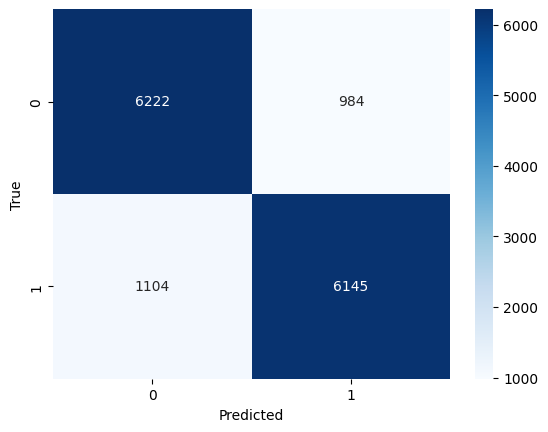

In [46]:
model1 = make_pipeline(vectorizer, MultinomialNB())
model1.fit(x_train, y_train)
predicted1 = model1.predict(x_test)
metricas(predicted1,y_test)

In [47]:
guardar_y_predecir(model1,"bayes_naive_vectorizer4")

Hago randomSearch para optimizar los hiperparámetros

In [11]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=40

#Conjunto de parámetros que quiero usar
params_grid = {
    'multinomialnb__alpha': [0.1, 0.4, 0.5, 1.0],
    'multinomialnb__force_alpha': [True, False],
    'multinomialnb__class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
    'multinomialnb__fit_prior': [True, False]
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    MultinomialNB()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, n_jobs=-1)

#Busco los hiperparamtros que optimizan F1 Score
model= randomcv.fit(x_train,y_train)


{'multinomialnb__force_alpha': True, 'multinomialnb__fit_prior': False, 'multinomialnb__class_prior': [0.5, 0.5], 'multinomialnb__alpha': 1.0}
              precision    recall  f1-score   support

           0      0.851     0.861     0.856      7206
           1      0.860     0.850     0.855      7249

    accuracy                          0.855     14455
   macro avg      0.856     0.855     0.855     14455
weighted avg      0.856     0.855     0.855     14455



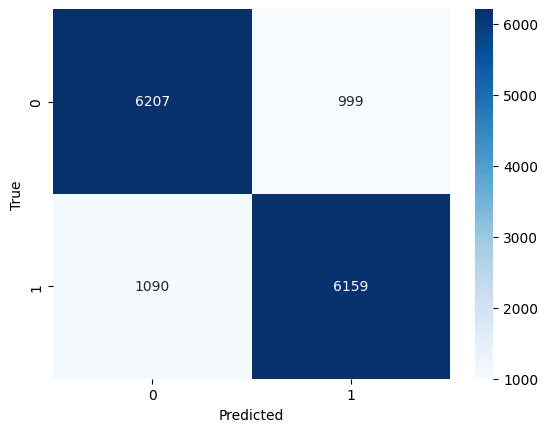

In [12]:
#Mejor estimador
best_bayes=model.best_estimator_

#Mejores parámetros
print(model.best_params_)

#Predicción con mejor estimador
y_pred=best_bayes.predict(x_test)

metricas(y_pred,y_test)

In [13]:
guardar_y_predecir(best_bayes,"bayes_naive_best_model_filtrado_final")

Pruebo optimizar más parametros, por partes:

In [18]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=40

#Conjunto de parámetros que quiero usar
params_grid = {
    'multinomialnb__alpha': np.arange(0.05, 1.05, 0.05), # intervalos de 0.05
    'multinomialnb__force_alpha': [True, False],
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    MultinomialNB()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, n_jobs=-1)

#Busco los hiperparamtros que optimizan F1 Score
model= randomcv.fit(x_train,y_train)


{'multinomialnb__force_alpha': True, 'multinomialnb__alpha': 0.9500000000000001}
              precision    recall  f1-score   support

           0      0.850     0.862     0.856      7206
           1      0.861     0.848     0.855      7249

    accuracy                          0.855     14455
   macro avg      0.855     0.855     0.855     14455
weighted avg      0.855     0.855     0.855     14455



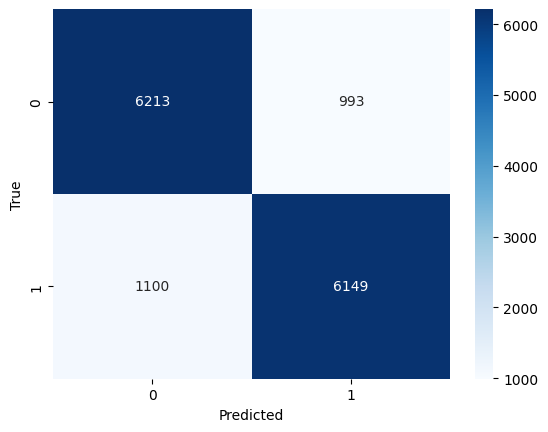

In [20]:
#Mejor estimador
best_bayes=model.best_estimator_

#Mejores parámetros
print(model.best_params_)

#Predicción con mejor estimador
y_pred=best_bayes.predict(x_test)

metricas(y_pred,y_test)

In [21]:
guardar_y_predecir(best_bayes,"bayes_naive_alpha")

Pruebo otro par de hiperparametros

In [22]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=40

#Conjunto de parámetros que quiero usar
params_grid = {
    'multinomialnb__alpha': [0.95],
    'multinomialnb__force_alpha': [True],
    'multinomialnb__class_prior': [None, [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]],
    'multinomialnb__fit_prior': [True, False]
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    MultinomialNB()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, n_jobs=-1)

#Busco los hiperparamtros que optimizan F1 Score
model= randomcv.fit(x_train,y_train)


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 10 is smaller than n_iter=40. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'multinomialnb__force_alpha': True, 'multinomialnb__fit_prior': False, 'multinomialnb__class_prior': None, 'multinomialnb__alpha': 0.95}
              precision    recall  f1-score   support

           0      0.851     0.861     0.856      7206
           1      0.860     0.850     0.855      7249

    accuracy                          0.855     14455
   macro avg      0.855     0.855     0.855     14455
weighted avg      0.855     0.855     0.855     14455



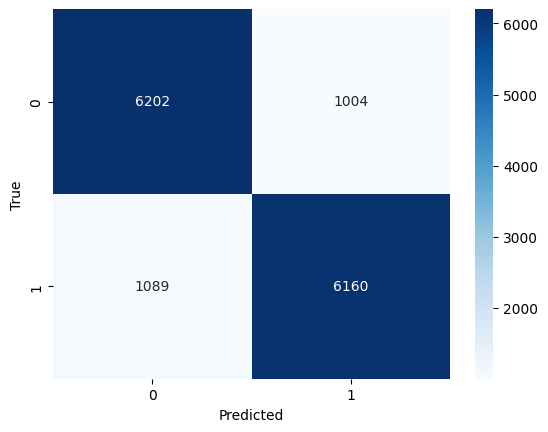

In [23]:
#Mejor estimador
best_bayes=model.best_estimator_

#Mejores parámetros
print(model.best_params_)

#Predicción con mejor estimador
y_pred=best_bayes.predict(x_test)

metricas(y_pred,y_test)

In [24]:
guardar_y_predecir(best_bayes,"bayes_naive_hiperparametros")

# 2) Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Build the model
modelRF = make_pipeline(vectorizer, RandomForestClassifier(n_jobs=-1))
# Indice de frecuencia invertido. Normaliza la cantidad de palabras.
# Le da mayor importancia a las palabras que menos aparecen

# Train the model using the training data
modelRF.fit(x_train, y_train)

# Predict the categories of the test data
predicted1 = modelRF.predict(x_test)

              precision    recall  f1-score   support

    negativo      0.830     0.855     0.842      7206
    positivo      0.851     0.826     0.838      7249

    accuracy                          0.840     14455
   macro avg      0.840     0.840     0.840     14455
weighted avg      0.841     0.840     0.840     14455



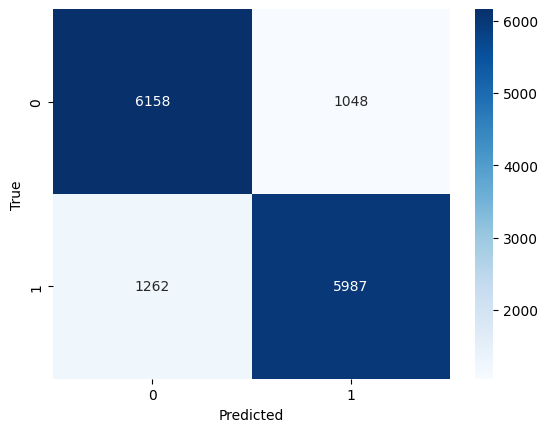

In [46]:
metricas(predicted1,y_test)

In [47]:
guardar_y_predecir(modelRF,"random_forest-filtrado")

Hago un randomsearch para optimizar los hiperparámetros

In [49]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=40

#Conjunto de parámetros que quiero usar
params_grid = { "randomforestclassifier__criterion" : ["gini", "entropy"], 
                "randomforestclassifier__min_samples_leaf" : [1, 5, 10], 
                "randomforestclassifier__min_samples_split" : [2, 4, 10, 16], 
                "randomforestclassifier__n_estimators": [10, 20, 50, 100],
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    RandomForestClassifier()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, n_jobs=-1) 

#Busco los hiperparamtros que optimizan F1 Score
model = randomcv.fit(x_train,y_train)

{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 16, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__criterion': 'entropy'}
              precision    recall  f1-score   support

    negativo      0.843     0.846     0.845      7206
    positivo      0.847     0.843     0.845      7249

    accuracy                          0.845     14455
   macro avg      0.845     0.845     0.845     14455
weighted avg      0.845     0.845     0.845     14455



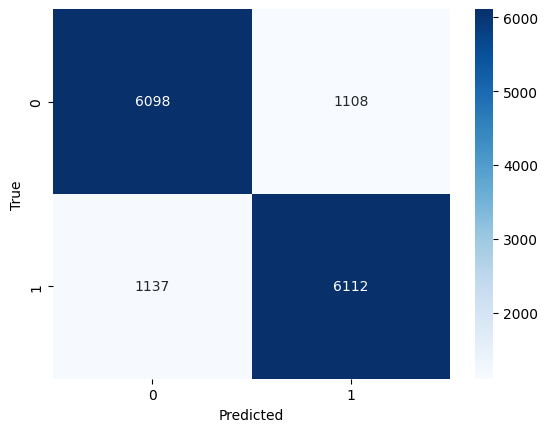

In [50]:
#Mejor estimador
best_RF=model.best_estimator_

#Mejores parametros
print(model.best_params_)

#Predicción con mejor estimador
y_pred=best_RF.predict(x_test)

metricas(y_pred,y_test)

In [51]:
guardar_y_predecir(best_RF,"random_forest_best-filtrado")

Pruebo otro 

# 3) XGBoost

              precision    recall  f1-score   support

           0      0.856     0.816     0.835      7206
           1      0.825     0.863     0.844      7249

    accuracy                          0.840     14455
   macro avg      0.840     0.840     0.839     14455
weighted avg      0.840     0.840     0.839     14455



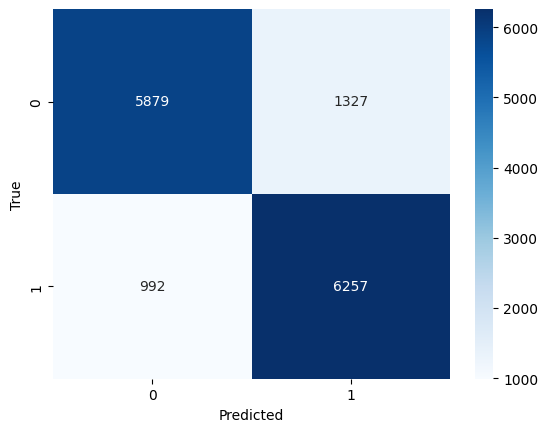

In [49]:
from xgboost import XGBClassifier
# Build the model

modelXGB = make_pipeline(vectorizer, XGBClassifier(n_jobs=-1))

# Train the model using the training data
modelXGB.fit(x_train, y_train)

# Predict the categories of the test data
predictedXGB = modelXGB.predict(x_test)

metricas(predictedXGB,y_test)

In [67]:
guardar_y_predecir(modelXGB,"XGBoost-filtrado")

Hago un randomSearch para optimizar los hiperparámetros

In [35]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=40

#Conjunto de parámetros que quiero usar
params_grid = {
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.05, 0.1, 0.15],
    'xgbclassifier__subsample': [0.6, 0.8, 1.0],
    'xgbclassifier__gamma': [0, 0.1, 0.5],
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    XGBClassifier()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, n_jobs=-1) 

#Busco los hiperparamtros que optimizan F1 Score
model_XGB = randomcv.fit(x_train,y_train)

In [36]:
#Mejores hiperparametros
print(model_XGB.best_params_)
#Mejor métrica
print(model_XGB.best_score_)

{'xgbclassifier__subsample': 0.8, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.15, 'xgbclassifier__gamma': 0.5}
0.831114970779238


              precision    recall  f1-score   support

           0      0.857     0.798     0.826      7206
           1      0.812     0.867     0.839      7249

    accuracy                          0.833     14455
   macro avg      0.834     0.833     0.833     14455
weighted avg      0.834     0.833     0.833     14455



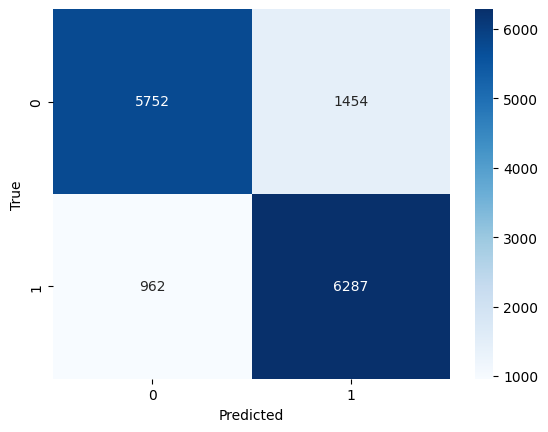

In [37]:
#Mejor estimador
best_XGB=model_XGB.best_estimator_

#Predicción con mejor estimador
y_pred=best_XGB.predict(x_test)

metricas(y_pred,y_test)

In [95]:
guardar_y_predecir(best_XGB,"xgboost_best-filtrado")

Pruebo otro:

In [51]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=87

#Conjunto de parámetros que quiero usar
params_grid = {
    'xgbclassifier__max_depth': [3, 5, 7, 9],
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1, 0.15],
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__subsample': [0.6, 0.8, 1.0],
    'xgbclassifier__gamma': [0, 0.1, 0.5],
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    XGBClassifier()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, verbose=1, n_jobs=-1) 

#Busco los hiperparamtros que optimizan F1 Score
model_XGB = randomcv.fit(x_train,y_train)

Fitting 5 folds for each of 87 candidates, totalling 435 fits


In [52]:
#Mejores hiperparametros
print(model_XGB.best_params_)
#Mejor métrica
print(model_XGB.best_score_)

{'xgbclassifier__subsample': 0.6, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__max_depth': 9, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.1}
0.852853161245626


              precision    recall  f1-score   support

           0      0.866     0.839     0.852      7206
           1      0.845     0.871     0.857      7249

    accuracy                          0.855     14455
   macro avg      0.855     0.855     0.855     14455
weighted avg      0.855     0.855     0.855     14455



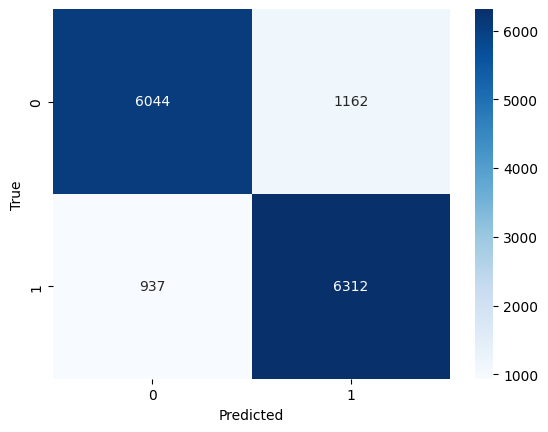

In [53]:
#Mejor estimador
best_XGB=model_XGB.best_estimator_

#Predicción con mejor estimador
y_pred=best_XGB.predict(x_test)

metricas(y_pred,y_test)

In [54]:
guardar_y_predecir(best_XGB,"xgboost_best-filtrado-2")

# Ensamble Voting

In [25]:

bayes_naive = cargar_modelo("./modelos/bayes_naive_hiperparametros.sav")
random_forest = cargar_modelo("./modelos/random_forest_best-filtrado.sav")
xgboost = cargar_modelo("./modelos/XGBoost-filtrado.sav")



In [26]:
from sklearn.ensemble import VotingClassifier

#Creo ensemble de Votación
voting = VotingClassifier(estimators = [('bayes_naive', bayes_naive), ('random_forest', random_forest), ('xgboost', xgboost)], voting = 'hard')

#Entreno el ensemble
voting.fit(x_train, y_train)

VotingClassifier(estimators=[('bayes_naive',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(max_features=40000,
                                                               stop_words=['de',
                                                                           'la',
                                                                           'que',
                                                                           'el',
                                                                           'en',
                                                                           'y',
                                                                           'a',
                                                                           'los',
                                                                           'del',
                                                                           'se',
                                                                           'las',
                                                                           'por',
                                                                           'un',
                                                                           'para',
                                                                           'con',
                                                                           'no',
                                                                           'una',
                                                                           'su',
                                                                           'al',
                                                                           'lo',
                                                                           'como',
                                                                           'más',
                                                                           'pero',
                                                                           'sus',
                                                                           'le',
                                                                           'ya',
                                                                           'o',
                                                                           'este',
                                                                           'sí',
                                                                           'porque', ...],
                                                               strip_accents='ascii')),
                                              ('multinomialnb',
                                               Multinomia...
                                                             gpu_id=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
   

              precision    recall  f1-score   support

           0      0.869     0.849     0.859      7206
           1      0.854     0.873     0.863      7249

    accuracy                          0.861     14455
   macro avg      0.861     0.861     0.861     14455
weighted avg      0.861     0.861     0.861     14455



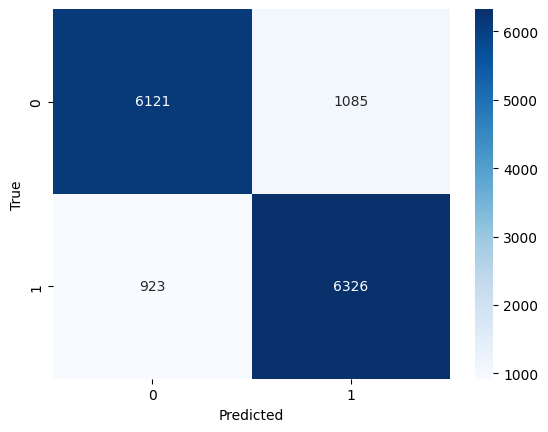

In [27]:
y_pred=voting.predict(x_test)

metricas(y_pred,y_test)

In [29]:
guardar_y_predecir(voting,"voting")

Optimizo hiperparámetros con RandomSearch

In [32]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=4

#Conjunto de parámetros que quiero usar
params_grid = {
    'voting': ['hard', 'soft'],
    'flatten_transform': [True, False],
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
voting = VotingClassifier(estimators = [('bayes_naive', bayes_naive), ('random_forest', random_forest), ('xgboost', xgboost)])

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=voting,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, verbose=1, n_jobs=-1) 

#Busco los hiperparamtros que optimizan F1 Score
model_voting = randomcv.fit(x_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


              precision    recall  f1-score   support

           0      0.880     0.858     0.869      7206
           1      0.862     0.884     0.873      7249

    accuracy                          0.871     14455
   macro avg      0.871     0.871     0.871     14455
weighted avg      0.871     0.871     0.871     14455



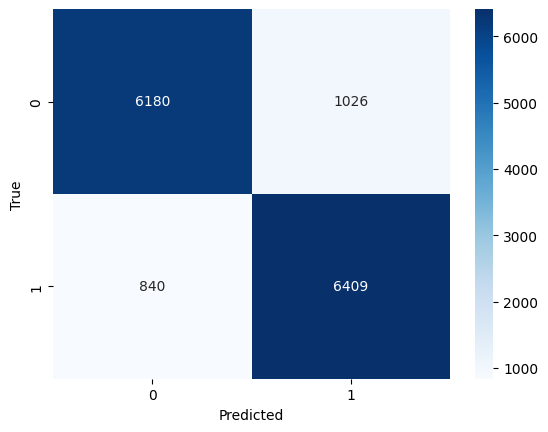

In [33]:
#Mejor estimador
best_voting=model_voting.best_estimator_

#Predicción con mejor estimador
y_pred=best_voting.predict(x_test)

metricas(y_pred,y_test)

In [34]:
guardar_y_predecir(best_voting,"voting_hiperparametros")

# Red neuronal

In [10]:
import tensorflow as tf
from tensorflow import keras

2023-06-29 00:30:51.332993: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 00:30:51.634460: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 00:30:52.827788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [22]:
# calcula la cantidad de clases

modelo1 = keras.Sequential([
    keras.layers.Dense(40000,input_shape=(1,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')])

modelo1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 40000)             80000     
                                                                 
 dense_7 (Dense)             (None, 100)               4000100   
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 4,080,201
Trainable params: 4,080,201
Non-trainable params: 0
_________________________________________________________________


In [20]:
modelo1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01), 
  loss='binary_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['AUC'], 
)

cant_epochs=100
modelo_red = modelo1.fit(x_train,y_train,epochs=cant_epochs,batch_size=50,verbose=False)

ValueError: in user code:

    File "/home/facundo/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/facundo/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/facundo/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/facundo/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/facundo/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/facundo/.local/lib/python3.9/site-packages/keras/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 2, but received input with shape (None, 1)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=string)
      • training=True
      • mask=None


In [23]:
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('neural_network', modelo1)
])

modelo1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01), 
  loss='binary_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['AUC'], 
)

pipeline.fit(x_train, y_train, neural_network__epochs=10, neural_network__batch_size=32)



Epoch 1/10


ValueError: in user code:

    File "/home/facundo/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/facundo/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/facundo/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/facundo/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/facundo/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/facundo/.local/lib/python3.9/site-packages/keras/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "dense_6" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 40000)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 40000), dtype=float32)
      • training=True
      • mask=None


In [ ]:
accuracy = pipeline.score(X_test, y_test)
print(accuracy)

raise ValueError(\n\n    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).\n    \n    Input 0 of layer \"dense_6\" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 40000)\n    \n    Call arguments received by layer 'sequential_2' (type Sequential):\n      • inputs=tf.Tensor(shape=(None, 40000), dtype=float32)\n      • training=True\n      • mask=None\n"
}

387/387 [==============================] - 0s 756us/step


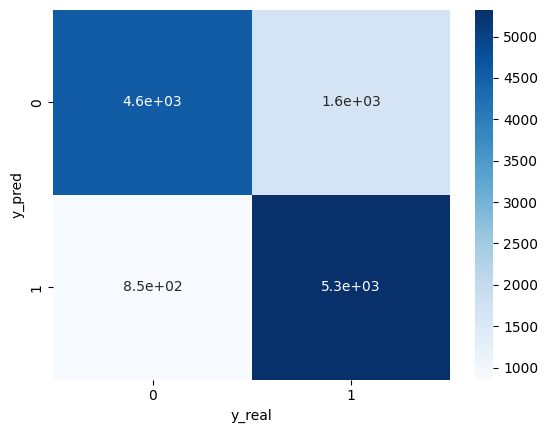

In [ ]:
y_predic_ej1 = modelo1.predict(x_test_norm)
y_predic_cat_ej1 = np.where(y_predic_ej1>0.4,1,0)

ds_validacion=pd.DataFrame(y_predic_cat_ej1,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()